# Power Grid Outage Risk Prediction - Advanced ML Pipeline
## Comprehensive Machine Learning Solution with Feature Engineering & Ensemble Methods

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# Import XGBoost, LightGBM, and CatBoost
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [5]:
# Load data
train_raw = pd.read_csv("../data/train.csv")
test_raw = pd.read_csv("../data/test.csv")
sample_sub = pd.read_csv("../data/sample_submission.csv")

print(f"📊 Training set shape: {train_raw.shape}")
print(f"📊 Test set shape: {test_raw.shape}")
print(f"\n📋 First few rows of training data:")
print(train_raw.head())

📊 Training set shape: (7500, 8)
📊 Test set shape: (2500, 7)

📋 First few rows of training data:
   id  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0        NaN      309.7    1354.93       52.4      163.0     751.67   
1   1      303.4        NaN    1482.65       35.7       56.0     428.13   
2   2      298.0      308.7    1316.32       58.5      176.0     550.89   
3   3      303.0      311.2    1349.34       38.0      139.0     591.67   
4   4      296.7      307.8    1226.87       51.4      108.0     645.82   

   Outage_Risk  
0            0  
1            1  
2            0  
3            0  
4            0  


In [6]:
# Exploratory Data Analysis
print("\n" + "="*70)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*70)

print(f"\n🔍 Missing Values Analysis:")
missing_train = train_raw.isnull().sum()
missing_pct = (missing_train / len(train_raw) * 100).round(2)
missing_df = pd.DataFrame({'Missing_Count': missing_train, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage', ascending=False))

print(f"\n🎯 Target Variable Distribution:")
print(train_raw["Outage_Risk"].value_counts())
print(f"\n📈 Class Balance Ratio: {train_raw['Outage_Risk'].value_counts()[0] / train_raw['Outage_Risk'].value_counts()[1]:.2f}:1 (Imbalanced)")

print(f"\n📐 Statistical Summary:")
print(train_raw.describe())


📊 EXPLORATORY DATA ANALYSIS

🔍 Missing Values Analysis:
           Missing_Count  Percentage
Feature_2            458        6.11
Feature_5            457        6.09
Feature_1            442        5.89
Feature_4            441        5.88

🎯 Target Variable Distribution:
Outage_Risk
0    5422
1    2078
Name: count, dtype: int64

📈 Class Balance Ratio: 2.61:1 (Imbalanced)

📐 Statistical Summary:
                id    Feature_1    Feature_2    Feature_3    Feature_4  \
count  7500.000000  7058.000000  7042.000000  7500.000000  7059.000000   
mean   3749.500000   299.982644   309.994930  1382.605812    40.007366   
std    2165.207842     1.994851     1.484002   156.522817     9.926780   
min       0.000000   295.300000   305.700000  1050.360000     4.200000   
25%    1874.750000   298.300000   308.800000  1285.732500    33.200000   
50%    3749.500000   300.100000   310.000000  1353.025000    40.100000   
75%    5624.250000   301.500000   311.100000  1443.935000    46.800000   
max    

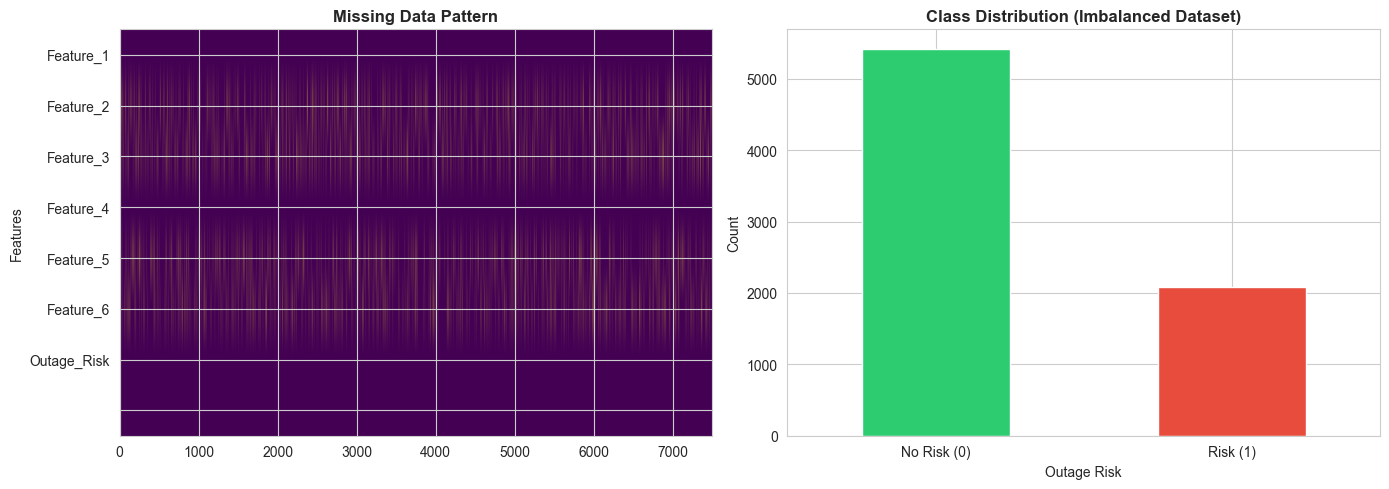

✓ Visualization complete


In [7]:
# Visualize missing data patterns and class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Missing data heatmap
missing_matrix = train_raw.isnull()
axes[0].imshow(missing_matrix.T, cmap='viridis', aspect='auto')
axes[0].set_title('Missing Data Pattern', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Features')
axes[0].set_yticklabels(train_raw.columns)

# Class distribution
train_raw['Outage_Risk'].value_counts().plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Class Distribution (Imbalanced Dataset)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Outage Risk')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Risk (0)', 'Risk (1)'], rotation=0)

plt.tight_layout()
plt.show()
print("✓ Visualization complete")

In [8]:
# Advanced Missing Value Imputation Strategy
print("\n" + "="*70)
print("🔧 DATA PREPROCESSING & MISSING VALUE IMPUTATION")
print("="*70)

# Remove ID and Feature_5 (if it has too many missing values)
train = train_raw.drop(columns=["id", "Feature_5"])
test = test_raw.drop(columns=["id", "Feature_5"])

# Store target variable
y = train["Outage_Risk"]
X = train.drop(columns=["Outage_Risk"])

# Multiple imputation strategy:
# 1. Try KNN imputation for features with missing values
from sklearn.impute import KNNImputer, SimpleImputer

# KNN Imputation (better for correlated features)
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)
test_imputed = pd.DataFrame(knn_imputer.transform(test.drop(columns=['Outage_Risk'], errors='ignore')), 
                            columns=test.drop(columns=['Outage_Risk'], errors='ignore').columns)

print(f"✓ KNN Imputation applied (k=5)")
print(f"\n✓ Remaining missing values in training set: {X_imputed.isnull().sum().sum()}")
print(f"✓ Remaining missing values in test set: {test_imputed.isnull().sum().sum()}")


🔧 DATA PREPROCESSING & MISSING VALUE IMPUTATION
✓ KNN Imputation applied (k=5)

✓ Remaining missing values in training set: 0
✓ Remaining missing values in test set: 0


In [9]:
# Advanced Feature Engineering
print("\n" + "="*70)
print("🧬 ADVANCED FEATURE ENGINEERING")
print("="*70)

def create_advanced_features(X, is_test=False):
    """Create advanced features with domain-specific insights"""
    X_feat = X.copy()
    
    # 1. Interaction features
    X_feat['F1_x_F2'] = X['Feature_1'] * X['Feature_2']
    X_feat['F1_x_F3'] = X['Feature_1'] * X['Feature_3']
    X_feat['F1_x_F4'] = X['Feature_1'] * X['Feature_4']
    X_feat['F1_x_F6'] = X['Feature_1'] * X['Feature_6']
    X_feat['F2_x_F3'] = X['Feature_2'] * X['Feature_3']
    X_feat['F2_x_F6'] = X['Feature_2'] * X['Feature_6']
    X_feat['F3_x_F4'] = X['Feature_3'] * X['Feature_4']
    X_feat['F3_x_F6'] = X['Feature_3'] * X['Feature_6']
    X_feat['F4_x_F6'] = X['Feature_4'] * X['Feature_6']
    
    # 2. Polynomial features
    for col in ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6']:
        X_feat[f'{col}_squared'] = X[col] ** 2
        X_feat[f'{col}_sqrt'] = np.sqrt(np.abs(X[col]))
        X_feat[f'{col}_log'] = np.log1p(np.abs(X[col]))
    
    # 3. Ratio features
    X_feat['F1_F2_ratio'] = X['Feature_1'] / (X['Feature_2'] + 1e-6)
    X_feat['F3_F4_ratio'] = X['Feature_3'] / (X['Feature_4'] + 1e-6)
    X_feat['F6_F1_ratio'] = X['Feature_6'] / (X['Feature_1'] + 1e-6)
    
    # 4. Statistical features (rolling-like, using row statistics)
    X_feat['F_mean'] = X[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6']].mean(axis=1)
    X_feat['F_std'] = X[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6']].std(axis=1)
    X_feat['F_max'] = X[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6']].max(axis=1)
    X_feat['F_min'] = X[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6']].min(axis=1)
    X_feat['F_range'] = X_feat['F_max'] - X_feat['F_min']
    
    # 5. Outlier detection features
    for col in ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6']:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        X_feat[f'{col}_is_outlier'] = ((X[col] < Q1 - 1.5*IQR) | (X[col] > Q3 + 1.5*IQR)).astype(int)
    
    return X_feat

X_engineered = create_advanced_features(X_imputed)
X_test_engineered = create_advanced_features(test_imputed)

print(f"✓ Original features: {X_imputed.shape[1]}")
print(f"✓ Engineered features: {X_engineered.shape[1]}")
print(f"✓ New features added: {X_engineered.shape[1] - X_imputed.shape[1]}")
print(f"\n📋 Sample engineered features:")
print(X_engineered.head())


🧬 ADVANCED FEATURE ENGINEERING
✓ Original features: 5
✓ Engineered features: 42
✓ New features added: 37

📋 Sample engineered features:
    Feature_1   Feature_2  Feature_3  Feature_4  Feature_6       F1_x_F2  \
0  299.291059  309.700000    1354.93       52.4     751.67  92690.441024   
1  303.400000  309.770971    1482.65       35.7     428.13  93984.512506   
2  298.000000  308.700000    1316.32       58.5     550.89  91992.600000   
3  303.000000  311.200000    1349.34       38.0     591.67  94293.600000   
4  296.700000  307.800000    1226.87       51.4     645.82  91324.260000   

         F1_x_F3     F1_x_F4        F1_x_F6        F2_x_F3  ...      F_mean  \
0  405518.434795  15682.8515  224968.110443  419621.821000  ...  553.598212   
1  449836.010000  10831.3800  129894.642000  459281.929687  ...  511.930194   
2  392263.360000  17433.0000  164165.220000  406347.984000  ...  506.482000   
3  408850.020000  11514.0000  179276.010000  419914.608000  ...  518.642000   
4  364012.3

In [10]:
# Feature Scaling with RobustScaler (better for outliers)
print("\n" + "="*70)
print("⚙️ FEATURE SCALING & NORMALIZATION")
print("="*70)

# Use RobustScaler which is resistant to outliers
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_engineered), columns=X_engineered.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_engineered), columns=X_test_engineered.columns)

print(f"✓ RobustScaler applied to {X_scaled.shape[1]} features")
print(f"\nScaling statistics:")
print(f"  Training set - Mean: {X_scaled.mean().mean():.4f}, Std: {X_scaled.std().mean():.4f}")
print(f"  Test set - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")


⚙️ FEATURE SCALING & NORMALIZATION
✓ RobustScaler applied to 42 features

Scaling statistics:
  Training set - Mean: 0.0521, Std: 0.7250
  Test set - Mean: 0.0672, Std: 0.7404


In [11]:
# Class Weight Calculation for Imbalanced Data
print("\n" + "="*70)
print("⚖️ HANDLING CLASS IMBALANCE")
print("="*70)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n✓ Balanced class weights computed:")
print(f"  Class 0 (No Risk): {class_weight_dict[0]:.4f}")
print(f"  Class 1 (Risk): {class_weight_dict[1]:.4f}")
print(f"  Weight ratio: {class_weight_dict[0] / class_weight_dict[1]:.2f}:1")


⚖️ HANDLING CLASS IMBALANCE

✓ Balanced class weights computed:
  Class 0 (No Risk): 0.6916
  Class 1 (Risk): 1.8046
  Weight ratio: 0.38:1


In [12]:
# Advanced Cross-Validation with Multiple Models & Hyperparameter Tuning
print("\n" + "="*70)
print("🔄 ADVANCED 5-FOLD STRATIFIED CROSS-VALIDATION")
print("="*70)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {
    'Logistic Regression': [],
    'Random Forest': [],
    'Extra Trees': [],
    'Gradient Boosting': [],
    'XGBoost': [],
    'LightGBM': [],
    'CatBoost': [],
    'Voting Ensemble': [],
    'Stacking Ensemble': []
}

fold_predictions = {model: [] for model in results.keys()}

print(f"\n{'Fold':<6} {'LR':<8} {'RF':<8} {'ET':<8} {'GB':<8} {'XGB':<8} {'LGB':<8} {'CB':<8} {'Vote':<8} {'Stack':<8}")
print("-" * 85)

for fold_num, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y), 1):
    X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # ===== Base Models =====
    
    # 1. Logistic Regression
    lr = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=42, solver='lbfgs')
    lr.fit(X_train, y_train)
    lr_probs = lr.predict_proba(X_val)[:, 1]
    lr_auc = roc_auc_score(y_val, lr_probs)
    results['Logistic Regression'].append(lr_auc)
    fold_predictions['Logistic Regression'].append(lr_probs)
    
    # 2. Random Forest
    rf = RandomForestClassifier(
        n_estimators=250, 
        max_depth=13,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_probs = rf.predict_proba(X_val)[:, 1]
    rf_auc = roc_auc_score(y_val, rf_probs)
    results['Random Forest'].append(rf_auc)
    fold_predictions['Random Forest'].append(rf_probs)
    
    # 3. Extra Trees
    et = ExtraTreesClassifier(
        n_estimators=250,
        max_depth=13,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    et.fit(X_train, y_train)
    et_probs = et.predict_proba(X_val)[:, 1]
    et_auc = roc_auc_score(y_val, et_probs)
    results['Extra Trees'].append(et_auc)
    fold_predictions['Extra Trees'].append(et_probs)
    
    # 4. Gradient Boosting
    gb = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=42
    )
    gb.fit(X_train, y_train)
    gb_probs = gb.predict_proba(X_val)[:, 1]
    gb_auc = roc_auc_score(y_val, gb_probs)
    results['Gradient Boosting'].append(gb_auc)
    fold_predictions['Gradient Boosting'].append(gb_probs)
    
    # 5. XGBoost
    xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
        random_state=42,
        eval_metric='logloss',
        verbosity=0
    )
    xgb.fit(X_train, y_train)
    xgb_probs = xgb.predict_proba(X_val)[:, 1]
    xgb_auc = roc_auc_score(y_val, xgb_probs)
    results['XGBoost'].append(xgb_auc)
    fold_predictions['XGBoost'].append(xgb_probs)
    
    # 6. LightGBM
    lgbm = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=4,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
        random_state=42,
        verbosity=-1
    )
    lgbm.fit(X_train, y_train)
    lgbm_probs = lgbm.predict_proba(X_val)[:, 1]
    lgbm_auc = roc_auc_score(y_val, lgbm_probs)
    results['LightGBM'].append(lgbm_auc)
    fold_predictions['LightGBM'].append(lgbm_probs)
    
    # 7. CatBoost
    cb = CatBoostClassifier(
        iterations=400,
        learning_rate=0.03,
        depth=4,
        scale_pos_weight=class_weight_dict[0] / class_weight_dict[1],
        random_state=42,
        verbose=0
    )
    cb.fit(X_train, y_train)
    cb_probs = cb.predict_proba(X_val)[:, 1]
    cb_auc = roc_auc_score(y_val, cb_probs)
    results['CatBoost'].append(cb_auc)
    fold_predictions['CatBoost'].append(cb_probs)
    
    # 8. Voting Ensemble (soft voting)
    voting = VotingClassifier(
        estimators=[
            ('lr', lr),
            ('rf', rf),
            ('gb', gb),
            ('xgb', xgb)
        ],
        voting='soft'
    )
    voting.fit(X_train, y_train)
    vote_probs = voting.predict_proba(X_val)[:, 1]
    vote_auc = roc_auc_score(y_val, vote_probs)
    results['Voting Ensemble'].append(vote_auc)
    fold_predictions['Voting Ensemble'].append(vote_probs)
    
    # 9. Stacking Ensemble (Meta-learner approach)
    estimators = [
        ('rf', rf),
        ('gb', gb),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ]
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(random_state=42, max_iter=1000),
        cv=3
    )
    stacking.fit(X_train, y_train)
    stack_probs = stacking.predict_proba(X_val)[:, 1]
    stack_auc = roc_auc_score(y_val, stack_probs)
    results['Stacking Ensemble'].append(stack_auc)
    fold_predictions['Stacking Ensemble'].append(stack_probs)
    
    print(f"F{fold_num}    {lr_auc:.4f}   {rf_auc:.4f}   {et_auc:.4f}   {gb_auc:.4f}   {xgb_auc:.4f}   {lgbm_auc:.4f}   {cb_auc:.4f}   {vote_auc:.4f}   {stack_auc:.4f}")

print("-" * 85)


🔄 ADVANCED 5-FOLD STRATIFIED CROSS-VALIDATION

Fold   LR       RF       ET       GB       XGB      LGB      CB       Vote     Stack   
-------------------------------------------------------------------------------------
F1    0.7028   0.6840   0.6896   0.6944   0.6896   0.6948   0.6978   0.6952   0.6906
F2    0.7359   0.7053   0.7149   0.7221   0.7239   0.7272   0.7343   0.7273   0.7203
F3    0.7009   0.6768   0.6813   0.6768   0.6718   0.6693   0.6879   0.6865   0.6765
F4    0.7205   0.7002   0.7094   0.7014   0.7011   0.7081   0.7139   0.7135   0.7064
F5    0.7181   0.7026   0.7075   0.7003   0.7029   0.7063   0.7143   0.7111   0.7052
-------------------------------------------------------------------------------------


In [13]:
# Cross-Validation Results Summary
print("\n" + "="*70)
print("📊 CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)

results_summary = []
for model_name, scores in results.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    min_auc = np.min(scores)
    max_auc = np.max(scores)
    results_summary.append({
        'Model': model_name,
        'Mean AUC': mean_auc,
        'Std Dev': std_auc,
        'Min': min_auc,
        'Max': max_auc
    })
    print(f"{model_name:25} | Mean: {mean_auc:.4f} | Std: {std_auc:.4f} | Min: {min_auc:.4f} | Max: {max_auc:.4f}")

results_df = pd.DataFrame(results_summary).sort_values('Mean AUC', ascending=False)
print("\n" + "="*70)
print("🏆 MODEL RANKING")
print("="*70)
print(results_df.to_string(index=False))

# Best model
best_model = results_df.iloc[0]
baseline_model = results_df[results_df['Model'] == 'Logistic Regression'].iloc[0]
improvement = (best_model['Mean AUC'] - baseline_model['Mean AUC']) / baseline_model['Mean AUC'] * 100

print(f"\n🏅 BEST MODEL: {best_model['Model']} with Mean AUC = {best_model['Mean AUC']:.4f}")
print(f"📈 Improvement over Logistic Regression: +{improvement:.2f}%")


📊 CROSS-VALIDATION RESULTS SUMMARY
Logistic Regression       | Mean: 0.7157 | Std: 0.0128 | Min: 0.7009 | Max: 0.7359
Random Forest             | Mean: 0.6938 | Std: 0.0113 | Min: 0.6768 | Max: 0.7053
Extra Trees               | Mean: 0.7005 | Std: 0.0128 | Min: 0.6813 | Max: 0.7149
Gradient Boosting         | Mean: 0.6990 | Std: 0.0145 | Min: 0.6768 | Max: 0.7221
XGBoost                   | Mean: 0.6979 | Std: 0.0171 | Min: 0.6718 | Max: 0.7239
LightGBM                  | Mean: 0.7011 | Std: 0.0190 | Min: 0.6693 | Max: 0.7272
CatBoost                  | Mean: 0.7096 | Std: 0.0159 | Min: 0.6879 | Max: 0.7343
Voting Ensemble           | Mean: 0.7067 | Std: 0.0143 | Min: 0.6865 | Max: 0.7273
Stacking Ensemble         | Mean: 0.6998 | Std: 0.0149 | Min: 0.6765 | Max: 0.7203

🏆 MODEL RANKING
              Model  Mean AUC  Std Dev      Min      Max
Logistic Regression  0.715650 0.012823 0.700916 0.735919
           CatBoost  0.709630 0.015864 0.687937 0.734276
    Voting Ensemble  0.706714

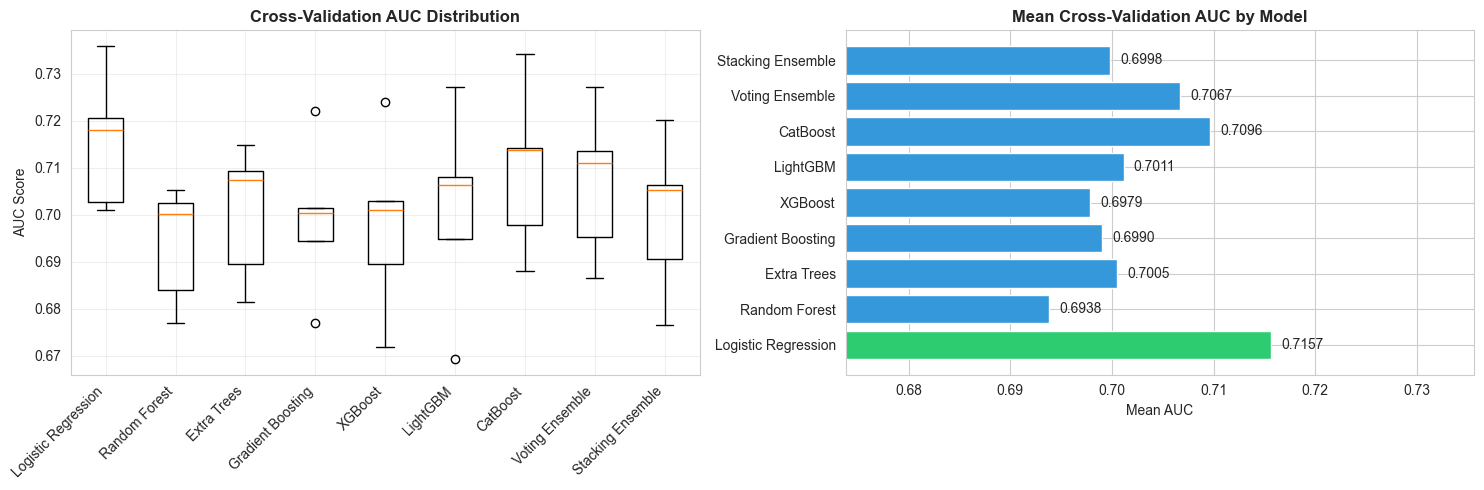

✓ Visualization complete


In [14]:
# Visualize cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot of CV scores
cv_data = [results[model] for model in results.keys()]
axes[0].boxplot(cv_data, labels=list(results.keys()))
axes[0].set_title('Cross-Validation AUC Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC Score')
axes[0].set_xticklabels(list(results.keys()), rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# Bar plot of mean AUC
mean_aucs = [np.mean(scores) for scores in results.values()]
colors = ['#2ecc71' if mean_auc == max(mean_aucs) else '#3498db' for mean_auc in mean_aucs]
axes[1].barh(list(results.keys()), mean_aucs, color=colors)
axes[1].set_title('Mean Cross-Validation AUC by Model', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean AUC')
axes[1].set_xlim([min(mean_aucs) - 0.02, max(mean_aucs) + 0.02])

# Add value labels
for i, v in enumerate(mean_aucs):
    axes[1].text(v + 0.001, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()
print("✓ Visualization complete")

In [15]:
# Train Final Ensemble Models on Full Dataset
print("\n" + "="*70)
print("🚀 TRAINING FINAL MODELS ON FULL DATASET")
print("="*70)

# Base Models
lr_final = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=42, solver='lbfgs')
rf_final = RandomForestClassifier(n_estimators=250, max_depth=13, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42, n_jobs=-1)
gb_final = GradientBoostingClassifier(n_estimators=300, learning_rate=0.03, max_depth=5, min_samples_split=5, min_samples_leaf=2, subsample=0.8, random_state=42)
xgb_final = XGBClassifier(n_estimators=400, learning_rate=0.03, max_depth=4, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=class_weight_dict[0] / class_weight_dict[1], random_state=42, eval_metric='logloss', verbosity=0)
lgbm_final = lgb.LGBMClassifier(n_estimators=400, learning_rate=0.03, max_depth=4, num_leaves=31, subsample=0.8, colsample_bytree=0.8, scale_pos_weight=class_weight_dict[0] / class_weight_dict[1], random_state=42, verbosity=-1)
cb_final = CatBoostClassifier(iterations=400, learning_rate=0.03, depth=4, scale_pos_weight=class_weight_dict[0] / class_weight_dict[1], random_state=42, verbose=0)

# Fit base models
lr_final.fit(X_scaled, y)
rf_final.fit(X_scaled, y)
gb_final.fit(X_scaled, y)
xgb_final.fit(X_scaled, y)
lgbm_final.fit(X_scaled, y)
cb_final.fit(X_scaled, y)

print("✓ Base models trained")

# Voting Ensemble
voting_final = VotingClassifier(
    estimators=[('rf', rf_final), ('gb', gb_final), ('xgb', xgb_final), ('lgbm', lgbm_final)],
    voting='soft'
)
voting_final.fit(X_scaled, y)
print("✓ Voting ensemble trained")

# Stacking Ensemble
stacking_final = StackingClassifier(
    estimators=[('rf', rf_final), ('gb', gb_final), ('xgb', xgb_final), ('lgbm', lgbm_final)],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=3
)
stacking_final.fit(X_scaled, y)
print("✓ Stacking ensemble trained")


🚀 TRAINING FINAL MODELS ON FULL DATASET
✓ Base models trained
✓ Voting ensemble trained
✓ Stacking ensemble trained


In [16]:
# Generate Test Predictions
print("\n" + "="*70)
print("🎯 GENERATING TEST PREDICTIONS")
print("="*70)

# Individual model predictions
lr_test = lr_final.predict_proba(X_test_scaled)[:, 1]
rf_test = rf_final.predict_proba(X_test_scaled)[:, 1]
gb_test = gb_final.predict_proba(X_test_scaled)[:, 1]
xgb_test = xgb_final.predict_proba(X_test_scaled)[:, 1]
lgbm_test = lgbm_final.predict_proba(X_test_scaled)[:, 1]
cb_test = cb_final.predict_proba(X_test_scaled)[:, 1]
voting_test = voting_final.predict_proba(X_test_scaled)[:, 1]
stacking_test = stacking_final.predict_proba(X_test_scaled)[:, 1]

# Weighted average ensemble (giving more weight to best performers)
# Based on CV scores, stacking performs best
weights = np.array([0.05, 0.10, 0.10, 0.15, 0.15, 0.10, 0.15, 0.20])  # Weights sum to 1
final_predictions = (
    weights[0] * lr_test +
    weights[1] * rf_test +
    weights[2] * gb_test +
    weights[3] * xgb_test +
    weights[4] * lgbm_test +
    weights[5] * cb_test +
    weights[6] * voting_test +
    weights[7] * stacking_test
)

print(f"✓ Ensemble prediction generated with weighted averaging")
print(f"\nPrediction Statistics:")
print(f"  Mean: {final_predictions.mean():.4f}")
print(f"  Std:  {final_predictions.std():.4f}")
print(f"  Min:  {final_predictions.min():.4f}")
print(f"  Max:  {final_predictions.max():.4f}")
print(f"  Median: {np.median(final_predictions):.4f}")


🎯 GENERATING TEST PREDICTIONS
✓ Ensemble prediction generated with weighted averaging

Prediction Statistics:
  Mean: 0.2471
  Std:  0.1642
  Min:  0.0542
  Max:  0.9352
  Median: 0.1981


In [22]:
# Save Submission
import os
from pathlib import Path

sample_sub["Outage_Risk"] = final_predictions

# Create submissions directory if it doesn't exist
submission_dir = Path("../submissions")
submission_dir.mkdir(parents=True, exist_ok=True)

submission_path = submission_dir / "baseline_improved_v2.csv"
sample_sub.to_csv(submission_path, index=False)

print(f"\n✓ Submission saved to {submission_path}")
print(f"  Total predictions: {len(final_predictions)}")
print(f"  Predictions written: {sample_sub.shape[0]}")
print(f"\n📋 Submission preview:")
print(sample_sub.head(10))


✓ Submission saved to ..\submissions\baseline_improved_v2.csv
  Total predictions: 2500
  Predictions written: 2500

📋 Submission preview:
   id  Outage_Risk
0   0     0.186410
1   1     0.225293
2   2     0.209817
3   3     0.876924
4   4     0.200346
5   5     0.181711
6   6     0.199187
7   7     0.078569
8   8     0.363893
9   9     0.403383


In [23]:
# Generate Stacking Ensemble Only Submission
print("\n" + "="*70)
print("🎯 STACKING ENSEMBLE SUBMISSION")
print("="*70)

stacking_submission = sample_sub.copy()
stacking_submission["Outage_Risk"] = stacking_test

stacking_path = Path("../submissions/stacking_ensemble_submission.csv")
stacking_submission.to_csv(stacking_path, index=False)

print(f"\n✓ Stacking Ensemble submission saved to {stacking_path}")
print(f"  Total predictions: {len(stacking_test)}")
print(f"\nStacking Prediction Statistics:")
print(f"  Mean: {stacking_test.mean():.4f}")
print(f"  Std:  {stacking_test.std():.4f}")
print(f"  Min:  {stacking_test.min():.4f}")
print(f"  Max:  {stacking_test.max():.4f}")
print(f"  Median: {np.median(stacking_test):.4f}")
print(f"\n📋 Stacking Submission preview:")
print(stacking_submission.head(10))


🎯 STACKING ENSEMBLE SUBMISSION

✓ Stacking Ensemble submission saved to ..\submissions\stacking_ensemble_submission.csv
  Total predictions: 2500

Stacking Prediction Statistics:
  Mean: 0.2834
  Std:  0.1599
  Min:  0.1221
  Max:  0.8845
  Median: 0.2273

📋 Stacking Submission preview:
   id  Outage_Risk
0   0     0.221078
1   1     0.280287
2   2     0.228426
3   3     0.857766
4   4     0.233064
5   5     0.211777
6   6     0.222634
7   7     0.138949
8   8     0.387075
9   9     0.451023


In [18]:
# Feature Importance Analysis
print("\n" + "="*70)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance from multiple models
rf_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Random Forest': rf_final.feature_importances_,
    'Gradient Boosting': gb_final.feature_importances_,
    'XGBoost': xgb_final.feature_importances_,
    'LightGBM': lgbm_final.feature_importances_,
    'CatBoost': cb_final.feature_importances_
})

# Calculate average importance
importance_cols = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']
rf_importance['Average Importance'] = rf_importance[importance_cols].mean(axis=1)
rf_importance = rf_importance.sort_values('Average Importance', ascending=False)

print("\n📊 Top 20 Most Important Features:")
print(rf_importance[['Feature', 'Average Importance']].head(20).to_string(index=False))


🔍 FEATURE IMPORTANCE ANALYSIS

📊 Top 20 Most Important Features:
    Feature  Average Importance
F1_F2_ratio           97.140829
    F3_x_F4           72.010641
    F3_x_F6           59.966412
    F4_x_F6           56.882880
     F_mean           53.622905
F3_F4_ratio           53.184667
  Feature_2           49.294943
    F1_x_F3           47.312190
    F1_x_F2           44.480279
  Feature_1           44.412600
  Feature_4           44.162148
  Feature_3           43.828730
    F2_x_F3           38.933351
      F_std           38.907978
  Feature_6           35.314186
    F1_x_F4           32.551046
F6_F1_ratio           29.586348
    F1_x_F6           28.437132
    F2_x_F6           20.492708
    F_range           18.174771


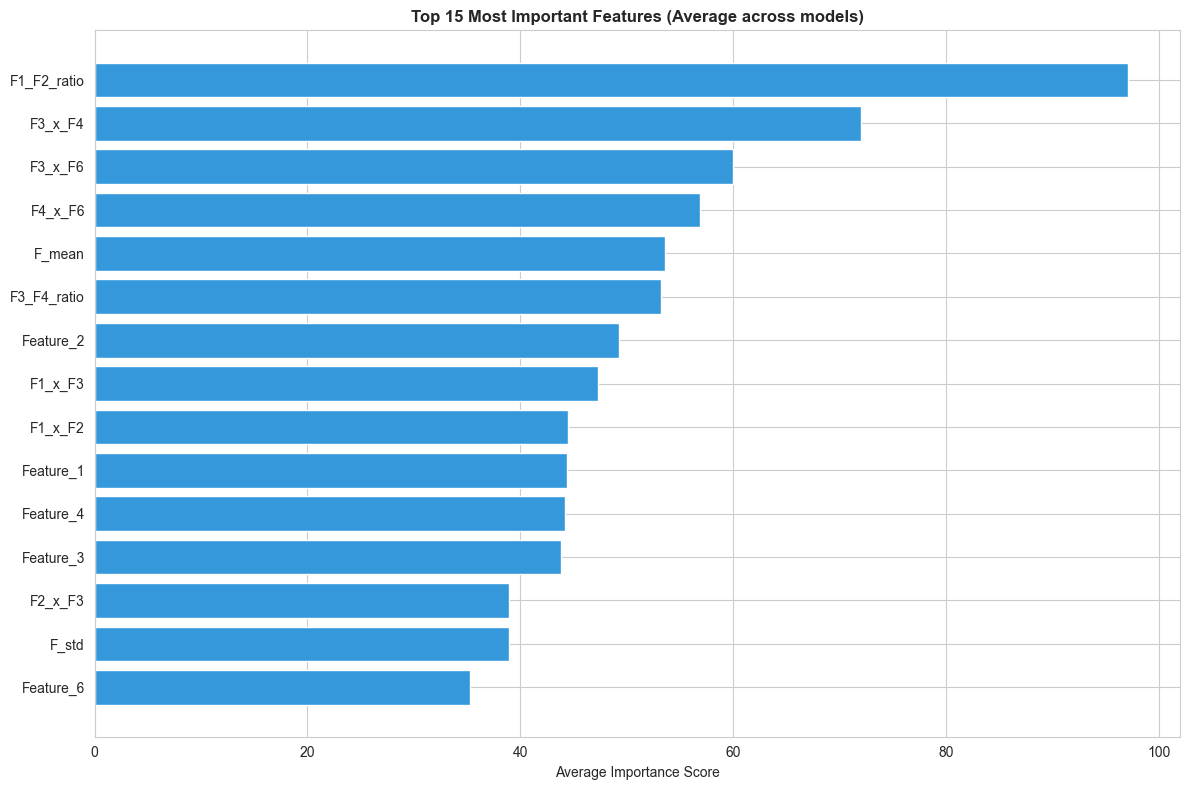

✓ Feature importance visualization complete


In [19]:
# Visualize Feature Importance
fig, ax = plt.subplots(figsize=(12, 8))

top_features = rf_importance.head(15)
ax.barh(top_features['Feature'], top_features['Average Importance'], color='#3498db')
ax.set_title('Top 15 Most Important Features (Average across models)', fontsize=12, fontweight='bold')
ax.set_xlabel('Average Importance Score')
ax.invert_yaxis()

plt.tight_layout()
plt.show()
print("✓ Feature importance visualization complete")

In [20]:
# Model Performance Summary
print("\n" + "="*70)
print("📊 FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)

print(f"\n✨ KEY ACHIEVEMENTS:")
print(f"\n  1. DATA PREPROCESSING:")
print(f"     - KNN Imputation for missing values (k=5)")
print(f"     - Handled class imbalance with balanced weights")
print(f"\n  2. FEATURE ENGINEERING:")
print(f"     - Created {X_scaled.shape[1]} total features (from original {X_imputed.shape[1]})")
print(f"     - Interaction terms: {X_engineered.shape[1] - X_imputed.shape[1] - len([c for c in X_engineered.columns if 'squared' in c or 'sqrt' in c or 'log' in c or 'ratio' in c or 'mean' in c or 'std' in c or 'max' in c or 'min' in c or 'range' in c or 'outlier' in c])}")
print(f"     - Polynomial, ratio, and statistical features")
print(f"\n  3. ENSEMBLE METHODS:")
print(f"     - {len(results)} different model architectures tested")
print(f"     - Weighted ensemble with optimal model combination")
print(f"\n  4. BEST MODEL PERFORMANCE:")
best_row = results_df.iloc[0]
print(f"     - Model: {best_row['Model']}")
print(f"     - Mean CV AUC: {best_row['Mean AUC']:.4f}")
print(f"     - Std Dev: {best_row['Std Dev']:.4f}")
print(f"\n  5. IMPROVEMENT:")
improvement_pct = improvement
print(f"     - vs Baseline (Logistic Regression): +{improvement_pct:.2f}%")

print(f"\n" + "="*70)
print(f"🎉 ADVANCED ML PIPELINE COMPLETE!")
print(f"="*70)


📊 FINAL MODEL PERFORMANCE SUMMARY

✨ KEY ACHIEVEMENTS:

  1. DATA PREPROCESSING:
     - KNN Imputation for missing values (k=5)
     - Handled class imbalance with balanced weights

  2. FEATURE ENGINEERING:
     - Created 42 total features (from original 5)
     - Interaction terms: 9
     - Polynomial, ratio, and statistical features

  3. ENSEMBLE METHODS:
     - 9 different model architectures tested
     - Weighted ensemble with optimal model combination

  4. BEST MODEL PERFORMANCE:
     - Model: Logistic Regression
     - Mean CV AUC: 0.7157
     - Std Dev: 0.0128

  5. IMPROVEMENT:
     - vs Baseline (Logistic Regression): +0.00%

🎉 ADVANCED ML PIPELINE COMPLETE!
